# SED Constraint on Temperature Profile

Started 31 March 2020. The goal of this is to create a covariance plot demonstrating how $A_V$ trades off with the power law governing the innermost parts of the disk. Can I do this in less than a month??

### Imports

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct29_copy import *
from fu_ori_classes_oct29_copy import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import scipy.signal as signal


import emcee
import corner
import time
%matplotlib inline 

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\pyfits\__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

In [3]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [4]:
def getDataArrayMOD(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(0,len(fulltxt), 2):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [5]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [6]:
direcToArray('C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/')

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

### Interpolating grid of stellar atmospheres on same grid as data:

First, reading in data...

In [7]:
txt_in = getDataArrayMOD('gaia_out.csv')
WAV_DAT = txt_in[:,0]
FLUX_DAT = txt_in[:,1]
FLUX_DAT_ERR = -0.01*FLUX_DAT

In [8]:
import spectres

In [9]:
def getInterpTable(st_atm_table, waves_data):
    out_table = dict()
    for key in ATM_TABLE:
        wav, lum = ATM_TABLE[key]
#         interp_func = interpolate.interp1d(wav, lum, kind = 'linear')
#         out_table[key] = waves_data, interp_func(waves_data)
        out_table[key] =  waves_data, spectres.spectres(waves_data, wav, lum)
    return out_table

In [10]:
WAVES_DATA_LOGGED = WAV_DAT

In [11]:
len(WAVES_DATA_LOGGED)

595

In [12]:
WAVES_DATA = 1e4*(10**WAVES_DATA_LOGGED)

In [13]:
ATM_TABLE_INTERP = getInterpTable(ATM_TABLE, WAVES_DATA)

In [14]:
ATM_TABLE_INTERP.keys()

dict_keys([(2000, 1.5), (2000, 4.0), (2100, 1.5), (2100, 4.0), (2200, 1.5), (2200, 4.0), (2300, 1.5), (2300, 4.0), (2400, 1.5), (2400, 4.0), (2500, 1.5), (2500, 4.0), (2600, 1.5), (2600, 4.0), (2700, 1.5), (2700, 4.0), (2800, 1.5), (2800, 4.0), (2900, 1.5), (2900, 4.0), (3000, 1.5), (3000, 4.0), (3100, 1.5), (3100, 4.0), (3200, 1.5), (3200, 4.0), (3300, 1.5), (3300, 4.0), (3400, 1.5), (3400, 4.0), (3500, 1.5), (3500, 4.0), (3600, 1.5), (3600, 4.0), (3700, 1.5), (3700, 4.0), (3800, 1.5), (3800, 4.0), (3900, 1.5), (3900, 4.0), (4000, 1.5), (4000, 4.0), (4100, 1.5), (4100, 4.0), (4200, 1.5), (4200, 4.0), (4300, 1.5), (4300, 4.0), (4400, 1.5), (4400, 4.0), (4500, 1.5), (4500, 4.0), (4600, 1.5), (4600, 4.0), (4700, 1.5), (4700, 4.0), (4800, 1.5), (4800, 4.0), (4900, 1.5), (4900, 4.0), (5000, 1.5), (5000, 4.0), (5100, 1.5), (5100, 4.0), (5200, 1.5), (5200, 4.0), (5300, 1.5), (5300, 4.0), (5400, 1.5), (5400, 4.0), (5500, 1.5), (5500, 4.0), (5600, 1.5), (5600, 4.0), (5700, 1.5), (5700, 4.0), (

In [15]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = 0
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, dist, grav, direc, a_v, atm_table, pl_index):
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table, pl_index)
        fuori.setAnnuliValues(10000, 2000, 200, 2*R_STAR)
        fuori.createAnnuliFromDirec(grav, direc, 'stellar atmospheres')
        fuori.createModelSpectrum('stellar atmospheres', False)
        self.fuori = fuori

### Making an instance of the class

In [16]:
PARAMS = [ 0.8379387 ,  0.49950058, -1.06484325]

In [179]:
M_STAR = PARAMS[0]*M_SUN
R_STAR = PARAMS[1]*R_SUN
R_OUTER = 100 * R_STAR
M_DOT = (10**PARAMS[2]) * 1e-6 * M_SUN / 3.154e7
A_V = 3.09
INC = 45.
DIST = 1.27e3*3.08567758128e18
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [180]:
%time gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
%time gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, a_v = A_V,dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index=-0.6)

Wall time: 0 ns
Wall time: 22.8 ms


### Quick minimization routine

In [72]:
def getLstSqrs(theta):
    m_star, r_star, m_dot= theta
    r_star = r_star*R_SUN
    m_dot = 10**m_dot
    m_star = m_star*M_SUN
    inc = 45
    m_dot = m_dot* 1e-6 * M_SUN / 3.154e7
    a_v = 3.09

    gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
    try:
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                          m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 1.5, \
                              direc = DIREC, atm_table=ATM_TABLE_INTERP)
    except:
        gaia17bpi_env.createFUOri(r_star = r_star*2, r_outer = R_OUTER, m_star = m_star,\
                          m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 1.5, \
                              direc = DIREC, atm_table=ATM_TABLE_INTERP)

    x = WAV_DAT
    # Converting units to properly compare model to data
    x_new = (10**x)*1e4
    modSpec = np.zeros(len(x_new))
    modSpec = gaia17bpi_env.fuori.mod_spec_lums
    modSpec = pyasl.unred(x_new, modSpec, -a_v/3.1)
    flux = np.cos(np.radians(inc))*modSpec/(2*np.pi*DIST**2)

    model = np.log10(x_new*flux*1e-8)
    data = FLUX_DAT

    return np.sum((model - data)**2)

In [158]:
from scipy import optimize
x0 = PARAMS
optimize.minimize(getLstSqrs, x0, method='Nelder-Mead', tol=1e-6)

TypeError: createFUOri() missing 1 required positional argument: 'pl_index'

In [181]:
wav, lum = gaia17bpi_env.fuori.mod_spec_waves, gaia17bpi_env.fuori.mod_spec_lums
lum = pyasl.unred(wav, lum, -A_V/3.1)

In [182]:
gaia17bpi_env.fuori.annuli[0].temp, gaia17bpi_env.fuori.getTotalLum()/L_SUN

(7800.0, 2.3151711769672)

In [183]:
gaia17bpi_env.fuori.temps

array([7800.        , 7600.        , 7400.        , 7200.        ,
       7000.        , 6800.        , 6600.        , 6400.        ,
       6400.        , 6200.        , 6000.        , 5800.        ,
       5600.        , 5400.        , 5200.        , 5000.        ,
       4800.        , 4600.        , 4400.        , 4200.        ,
       4000.        , 3800.        , 3600.        , 3400.        ,
       3200.        , 3000.        , 2800.        , 2600.        ,
       2400.        , 2200.        , 2000.        , 1794.91357061,
       1620.69768053, 1481.70627298, 1367.87989601, 1272.71169751,
       1191.79445618, 1122.02997134, 1061.17242776, 1007.55145052,
        959.89715039,  917.22571346,  878.76232989,  843.88792097,
        812.10147489,  782.99288107,  756.22298555,  731.50871266,
        708.61180574,  687.33019499,  667.49130061,  648.94678083,
        631.56837192,  615.2445629 ,  599.87791481,  585.38288267,
        571.68403286,  558.71457423,  546.41514001,  534.73277

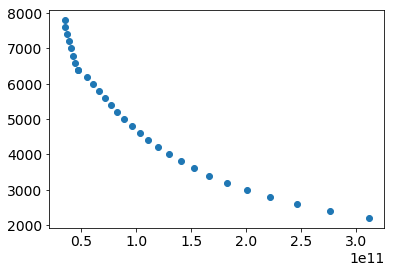

In [184]:
plt.plot(gaia17bpi_env.fuori.r_a[:30], gaia17bpi_env.fuori.temps[:30], 'o')

### Plotting data with model

In [185]:
model_wav = np.log10(wav*1e-4)
model_wav_flux =  np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2))

In [186]:
b, a = signal.butter(1, 0.35, 'low', analog=False)
filtered_signal = signal.filtfilt(b, a,  model_wav_flux)

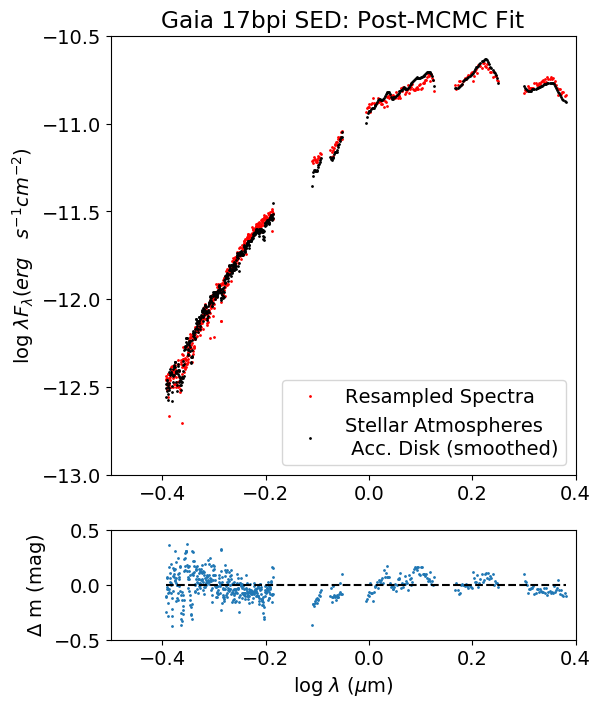

In [187]:
fig=plt.figure(figsize=(6, 8), dpi= 100)
gs = gridspec.GridSpec(2, 1,height_ratios=[4, 1])
plt.rcParams.update({'font.size': 14})

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


# plt.errorbar(WAV_DAT, FLUX_DAT, yerr=FLUX_DAT_ERR, marker='o', \
#              linestyle='', color='r', alpha=1, label='Palomar + IRTF \nResampled Spectra')

ax.plot(WAV_DAT, FLUX_DAT, 'ro', markersize=1, alpha=1, label='Resampled Spectra')
# ax.plot(model_wav,model_wav_flux, \
#          'ko', markersize = 1,  label='Stellar Atmospheres \n Acc. Disk (unsmoothed)')

ax.plot(model_wav, filtered_signal,'ko' , markersize = 1,  label='Stellar Atmospheres \n Acc. Disk (smoothed)')


# ax2.plot(model_wav, 100*(model_wav_flux - FLUX_DAT)/model_wav_flux, 'o', markersize=1)
# ax2.plot(model_wav, np.zeros(len(model_wav_flux)), 'k--')

ax2.plot(model_wav, (1/0.4)*np.log10((10**filtered_signal)/(10**FLUX_DAT)), 'o', markersize=1)
ax2.plot(model_wav, np.zeros(len(model_wav_flux)), 'k--')


ax2.set_xlabel(r'log $\lambda$ ($\mu$m)')
ax2.set_ylabel(r'$\Delta$ m (mag)')
ax2.set_xlim(-0.5, 0.4)
ax2.set_ylim(-0.5,0.5)


ax2.set_xlabel(r'log $\lambda$ ($\mu$m)')
ax.set_ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
# ax2.set_ylabel(r'Percent Error')

ax.set_title('Gaia 17bpi SED: Post-MCMC Fit')
ax.set_ylim(-13, -10.5)
ax.set_xlim(-0.5, 0.4)
# ax2.set_xlim(-0.5, 0.4)

ax.legend()
# plt.savefig("sed_gaia17bpi_75.png", dpi=200, bbox_inches='tight')
plt.show()

## MCMC Routine

In [45]:
def lnlike(theta, x, y, yerr):
    a_v, pl_index = theta
    r_star = R_STAR
    
    m_dot = M_DOT
    m_star = M_STAR
    try:
    
        gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                              m_dot = m_dot, inc = INC, a_v = a_v, dist = DIST, grav = 1.5, \
                                  direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index = pl_index)
    
    # Accounts for any random case where the model may not be generated properly given a certain combination
    # of parameters. This has only happened once, but it's presumably when the maximum temperature is too low.
    except:
        return 0
        
    
    # Converting units to properly compare model to data
    x_new = (10**x)*1e4
    modSpec = np.zeros(len(x_new))
    modSpec = gaia17bpi_env.fuori.mod_spec_lums
#     for i in range(len(x)):
#         modSpec[i] = gaia17bpi_env.getModSpecPoint(x[i], True)
    modSpec = pyasl.unred(x_new, modSpec, -a_v/3.1)
    flux = np.cos(np.radians(INC))*modSpec/(2*np.pi*DIST**2)
    

    model = np.log10(x_new*flux*1e-8)
    
    b, a = signal.butter(1, 0.35, 'low', analog=False)
    model = signal.filtfilt(b, a,  model)
    
    inv_sig = 1/yerr
    return np.sum(np.log((1/np.sqrt(2*np.pi))*inv_sig) - 0.5*((y - model)*inv_sig)**2)

In [80]:
A_V_LOW = 2.
A_V_HIGH = 4.5

PL_INDEX_LOW = -1.5
PL_INDEX_HIGH = 1.5

In [81]:
def lnprior(theta):
    a_v, pl_index = theta
    if A_V_LOW < a_v < A_V_HIGH\
    and PL_INDEX_LOW < pl_index < PL_INDEX_HIGH:
        return 0.0
    return -np.inf

In [82]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + lnlike(theta, x, y, yerr))

In [137]:
ndim, nwalkers = 2, 10
a_v_start = 4.1
pl_index_start = 0
start = np.array((a_v_start, pl_index_start))
pos = [start + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [138]:
x = WAV_DAT
y_meas = FLUX_DAT
y_err = FLUX_DAT_ERR

In [139]:
len(WAV_DAT), len(gaia17bpi_env.fuori.mod_spec_lums)

(595, 595)

In [140]:
lnprob((a_v_start, pl_index_start), x,y_meas,y_err)

-2793.874279914161

In [146]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_meas, y_err))
%time sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [09:10<00:00,  7.53it/s]


Wall time: 9min 11s


State([[ 3.11617122 -0.73110228]
 [ 3.07555008 -0.5593122 ]
 [ 2.98598119  0.01353059]
 [ 3.01496071 -0.03697617]
 [ 3.0014656  -0.24807459]
 [ 3.04469374 -0.41552076]
 [ 3.034989   -0.32910676]
 [ 3.07735494 -0.45867784]
 [ 3.05508803 -0.51681041]
 [ 3.0780185  -0.53782771]], log_prob=[686.48064612 686.60645408 684.10126853 685.1918687  683.88613783
 685.97878202 685.76916682 685.54292846 685.84915635 686.55110923], blobs=None, random_state=('MT19937', array([3309528022, 1843526997, 3392117585, 2569200065, 3330750509,
       2071424588,  642263526, 1205251775, 3839416385, 3064392136,
        691581604,  811361461,  524439941, 1703029201, 2810371985,
       1424245752, 3254115647, 2901274385, 3060734360, 3285348988,
       4082915811, 2659951098,  684963961, 3656483054, 2001334527,
       1043477942, 2175905855, 1846867767, 2422732448, 2756713605,
        201759393,  793742115, 3605603811,   30437175,   69937126,
       1151736928, 1787980647, 3559175043, 2870421379, 4242348532,
      

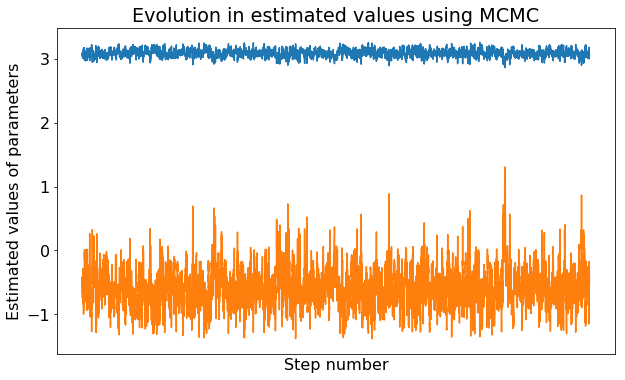

In [151]:
samples = sampler.chain[:, 2500:, :].reshape((-1, ndim))
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})

plt.plot(samples)
plt.xlabel('Step number')
plt.ylabel('Estimated values of parameters')
plt.title('Evolution in estimated values using MCMC')
plt.xticks([])
plt.show()

Quantiles:
[(0.16, 3.038896920602796), (0.5, 3.0890571144196626), (0.84, 3.1378852753733053)]
Quantiles:
[(0.16, -0.843129734000918), (0.5, -0.6144050283660625), (0.84, -0.3388601788841113)]


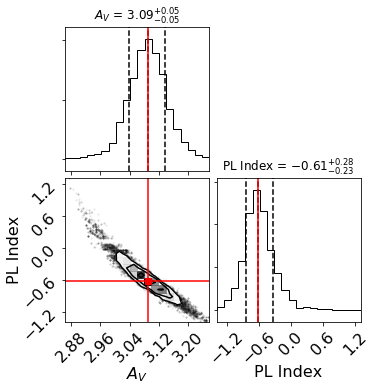

In [152]:
median_calcuated = np.median(samples, axis=0)

fig = corner.corner(samples, labels=[r'$A_V$', r'PL Index'], verbose=True,
                       quantiles=(0.16, 0.5,0.84), plot_contours=True, scale_hist=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(median_calcuated[i], color="r")
    
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(median_calcuated[xi], color="r")
        ax.axhline(median_calcuated[yi], color="r")
        ax.plot(median_calcuated[xi], median_calcuated[yi], "sr")

fig.show()
# fig.savefig("gaia17bpi_1028_55_100pts.png", dpi=140)